In [ ]:
# Install necessary libraries
!pip install transformers==4.35.2 pytesseract opencv-python-headless matplotlib torch torchvision tensorflow keras pillow google-cloud-vision mediapipe
!pip install tensorflow-cpu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.6/514.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires tensorboard<2.18,>=2.17, but you have tensorboard 2.18.0 which is incompatible.


In [ ]:
import os
import cv2
import pytesseract
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
import torch
import torchvision.models as models
import torch.nn.functional as F
from google.cloud import vision
from google.protobuf.json_format import MessageToJson
import mediapipe as mp

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [ ]:
# Setup Tesseract OCR
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,631 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,633 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8

In [ ]:
# Load models and utilities
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "placetheapikeyyoubitch"  # Replace with your JSON key file path

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

efficientnet_model = models.efficientnet_b0(pretrained=True).eval()
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 105MB/s]


In [ ]:
# Step 1: AI-Generated Image Check (EfficientNet)
def is_ai_generated_efficientnet(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    image_tensor = torch.tensor(np.array(image) / 255).permute(2, 0, 1).unsqueeze(0).float()
    output = efficientnet_model(image_tensor)
    probabilities = F.softmax(output[0], dim=0)
    top_prob, top_class = probabilities.max(0)
    return f"AI Detection Confidence (EfficientNet): {top_prob.item():.2f}"

In [ ]:
# Step 2: Face Detection and Analysis
def detect_and_analyze_faces(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)
    detected_faces = []
    if results.detections:
      for detection in results.detections:
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = image.shape
        bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
            int(bboxC.width * iw), int(bboxC.height * ih)
        x, y, w, h = bbox
        face_crop = image[y:y+h, x:x+w]
        face_image = Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))
        inputs = clip_processor(images=face_image, return_tensors="pt", padding=True)
        # Changed line below to use the image encoder of clip model.
        outputs = clip_model.vision_model(**inputs)
        # Extract the embedding from the last hidden state.
        face_features = outputs.last_hidden_state[:, 0, :]
        detected_faces.append({
            "box": bbox,
            "features": face_features.detach().cpu().numpy()
        })
    return detected_faces

In [ ]:
# Step 3: Check Image Region Consistency using CLIP
def check_region_consistency(image_path):
    image = Image.open(image_path)
    width, height = image.size
    regions = [
            (0, 0, width // 2, height // 2),
            (width // 2, 0, width, height // 2),
            (0, height // 2, width // 2, height),
            (width // 2, height // 2, width, height),
    ]
    region_features = []
    for box in regions:
        cropped_image = image.crop(box)
        inputs = clip_processor(images=cropped_image, return_tensors="pt", padding=True)
        # Changed line below to use the image encoder of clip model.
        outputs = clip_model.vision_model(**inputs)
        # Extract the embedding from the last hidden state.
        region_features.append(outputs.last_hidden_state[:, 0, :].detach().cpu().numpy())
    if len(region_features) < 2:
        return 0
    similarity =  F.cosine_similarity(torch.tensor(region_features[0]), torch.tensor(region_features[1]), dim=1).item()
    if len(region_features) > 2:
        for i in range(len(region_features)-1):
            for j in range(i+1, len(region_features)):
                 similarity += F.cosine_similarity(torch.tensor(region_features[i]), torch.tensor(region_features[j]), dim=1).item()
        similarity /= (len(region_features) * (len(region_features) - 1)/2)
    return similarity

In [ ]:
# Step 4: Extract Text from Image
def extract_text_from_image(image_path):
    image = Image.open(image_path)
    text = pytesseract.image_to_string(image, lang="eng+mal")
    return text.strip()

In [ ]:
# Step 5: Context Relevance Check
def check_relevance(image_path, text):
    image = Image.open(image_path)
    inputs = clip_processor(text=[text], images=image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)
    scores = outputs.logits_per_text.softmax(dim=1).cpu().detach().numpy()
    return scores[0][0]

In [ ]:
# Step 6: Reverse Image Search
def reverse_image_search(image_path):
    client = vision.ImageAnnotatorClient()
    with open(image_path, "rb") as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
    response = client.web_detection(image=image)
    results = {"similar_images": [], "entities": []}
    if response.web_detection.web_entities:
        results["entities"] = [entity.description for entity in response.web_detection.web_entities]
    if response.web_detection.full_matching_images:
        results["similar_images"] = [image.url for image in response.web_detection.full_matching_images]
    return results

In [ ]:
# Step 7: Tampering Detection (Edge Map and Percentage)
def detect_tampering(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    tampering_percentage = np.sum(edges > 0) / edges.size * 100
    return edges, tampering_percentage

In [ ]:


# Step 8: Main Fake Image Detection Pipeline (Updated)
def fake_image_pipeline(image_path, text=None):
    # Step 1: AI-Generated Check (EfficientNet)
    ai_generated = is_ai_generated_efficientnet(image_path)

    # Step 2: Face Detection and Analysis
    face_data = detect_and_analyze_faces(image_path)

    # Step 3: Image Region Consistency Check
    region_consistency = check_region_consistency(image_path)

    # Step 4: Extract Text from Image
    extracted_text = extract_text_from_image(image_path)

    # Step 5: Context Relevance Check
    relevance_score = None
    if text:
        relevance_score = check_relevance(image_path, text)

    # Step 6: Reverse Image Search
    reverse_search_results = reverse_image_search(image_path)

    # Step 7: Tampering Detection
    tampering_edges, tampering_percentage = detect_tampering(image_path)

    # Final Report
    report = {
        "AI-Generated": ai_generated,
        "Face Data": face_data,
        "Region Consistency": region_consistency,
        "Extracted Text": extracted_text,
        "Relevance Score": relevance_score,
        "Reverse Image Search Results": reverse_search_results,
        "Tampering Percentage": f"{tampering_percentage:.2f}%"
    }

    # Compute Average Score and Fake Prediction
    scores = []
    if "Confidence" in ai_generated:
        scores.append(float(ai_generated.split(":")[-1]))
    if region_consistency:
       scores.append(region_consistency)
    if relevance_score:
        scores.append(relevance_score)
    if tampering_percentage:
       scores.append(tampering_percentage / 100)
    average_score = np.mean(scores) if scores else 0
    is_fake = average_score > 0.5  # Threshold for fake determination

    return report, tampering_edges, average_score, is_fake



Saving sensors-21-07367-g001-550.jpg to sensors-21-07367-g001-550.jpg
Enter the accompanying text description for the image:fake

Processing: sensors-21-07367-g001-550.jpg
AI-Generated: AI Detection Confidence (EfficientNet): 0.29
Face Data:
   {'box': (77, 77, 107, 107), 'features': array([[-1.75174251e-02,  8.58892351e-02,  1.70019954e-01,
        -6.19847059e-01,  3.83107126e-01, -5.94610691e-01,
        -1.04252994e-02,  9.36890393e-03, -7.96032310e-01,
        -2.45590448e-01,  5.29715568e-02,  1.35657802e-01,
        -4.33107838e-02, -3.58838364e-02,  8.62859413e-02,
        -2.71173358e-01,  1.76673800e-01, -2.82680571e-01,
        -2.38347143e-01, -1.92843288e-01,  1.21329702e-01,
        -3.56827945e-01, -7.57662132e-02,  1.93969935e-01,
        -7.37517357e-01, -1.73351988e-01,  4.33589011e-01,
         1.41638070e-01, -1.04836166e-01,  1.56507164e-01,
        -3.78793120e-01,  5.34270369e-02, -2.35079467e-01,
         4.11522612e-02, -5.21666527e-01, -1.40917972e-01,
       

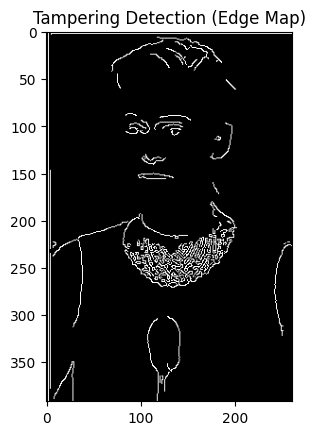

In [ ]:



# Upload files
from google.colab import files
uploaded = files.upload()

# Provide accompanying text
text_description = input("Enter the accompanying text description for the image:")

# Process each uploaded image
for image_name in uploaded.keys():
    print(f"\nProcessing: {image_name}")
    report, tampering_edges, avg_score, is_fake = fake_image_pipeline(image_name, text=text_description)

    # Display Results
    for key, value in report.items():
        if isinstance(value, dict):
            print(f"{key}:")
            for sub_key, sub_value in value.items():
                print(f"  {sub_key}: {sub_value}")
        elif isinstance(value, list):
             print(f"{key}:")
             for item in value:
                  print(f"   {item}")
        else:
            print(f"{key}: {value}")

    print(f"Average Score: {avg_score:.2f}")
    print(f"Fake Prediction: {'Fake' if is_fake else 'Not Fake'}")

    # Display Tampering Edges
    plt.imshow(tampering_edges, cmap='gray')
    plt.title("Tampering Detection (Edge Map)")
    plt.show()